## Import Libraries

In [1]:
# import system libs
import os
import itertools

# import data handling tools
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# ignore the warnings
import warnings
warnings.filterwarnings('ignore')

# Importing Traing Data

In [7]:
# Generate data paths with labels
train_data_dir = "archive/Training"
filepaths = []
labels = []

# Get folders names
# folds = os.listdir(train_data_dir)
# print(folds)
folds = [f for f in os.listdir(train_data_dir) if not f.startswith('.')]
for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')

train_df = pd.concat([Fseries, Lseries], axis= 1)

In [8]:
train_df

,filepaths,labels
0,archive/Training/pituitary/Tr-pi_0505.jpg,pituitary
1,archive/Training/pituitary/Tr-pi_0263.jpg,pituitary
2,archive/Training/pituitary/Tr-pi_0277.jpg,pituitary
3,archive/Training/pituitary/Tr-pi_1169.jpg,pituitary
4,archive/Training/pituitary/Tr-pi_0511.jpg,pituitary
...,...,...
5707,archive/Training/meningioma/Tr-me_1053.jpg,meningioma
5708,archive/Training/meningioma/Tr-me_0403.jpg,meningioma
5709,archive/Training/meningioma/Tr-me_0365.jpg,meningioma
5710,archive/Training/meningioma/Tr-me_0371.jpg,meningioma


# Importing Testing DataSet

In [9]:
# Generate data paths with labels
test_data_dir = 'archive/Testing'
filepaths = []
labels = []

# Get folders names
folds = [f for f in os.listdir(train_data_dir) if not f.startswith('.')]

for fold in folds:
    foldpath = os.path.join(test_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')

ts_df = pd.concat([Fseries, Lseries], axis= 1)

In [10]:
ts_df

,filepaths,labels
0,archive/Testing/pituitary/Te-pi_0233.jpg,pituitary
1,archive/Testing/pituitary/Te-pi_0227.jpg,pituitary
2,archive/Testing/pituitary/Te-pi_0019.jpg,pituitary
3,archive/Testing/pituitary/Te-pi_0031.jpg,pituitary
4,archive/Testing/pituitary/Te-pi_0025.jpg,pituitary
...,...,...
1306,archive/Testing/meningioma/Te-me_0080.jpg,meningioma
1307,archive/Testing/meningioma/Te-me_0094.jpg,meningioma
1308,archive/Testing/meningioma/Te-me_0137.jpg,meningioma
1309,archive/Testing/meningioma/Te-me_0123.jpg,meningioma


# Data preprocessing

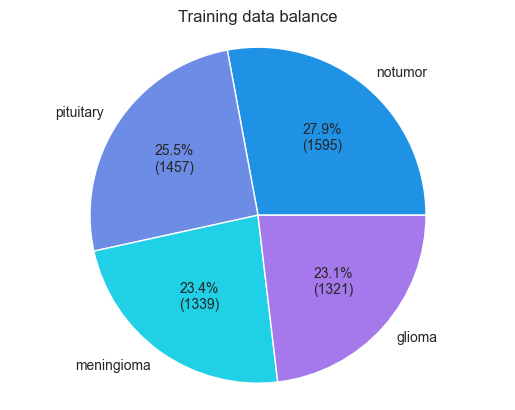

In [11]:
data_balance = train_df.labels.value_counts()


def custom_autopct(pct):
    total = sum(data_balance)
    val = int(round(pct*total/100.0))
    return "{:.1f}%\n({:d})".format(pct, val)


# pie chart for data balance
plt.pie(data_balance, labels = data_balance.index, autopct=custom_autopct, colors = ["#2092E6","#6D8CE6","#20D0E6","#A579EB"])
plt.title("Training data balance")
plt.axis("equal")
plt.show()

In [12]:
#data is balanced

In [13]:
# valid and test dataframe
valid_df, test_df = train_test_split(ts_df,  train_size= 0.5, shuffle= True, random_state= 42)

In [14]:
# crobed image size
batch_size = 16
img_size = (224, 224)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


#### Display sample from train data

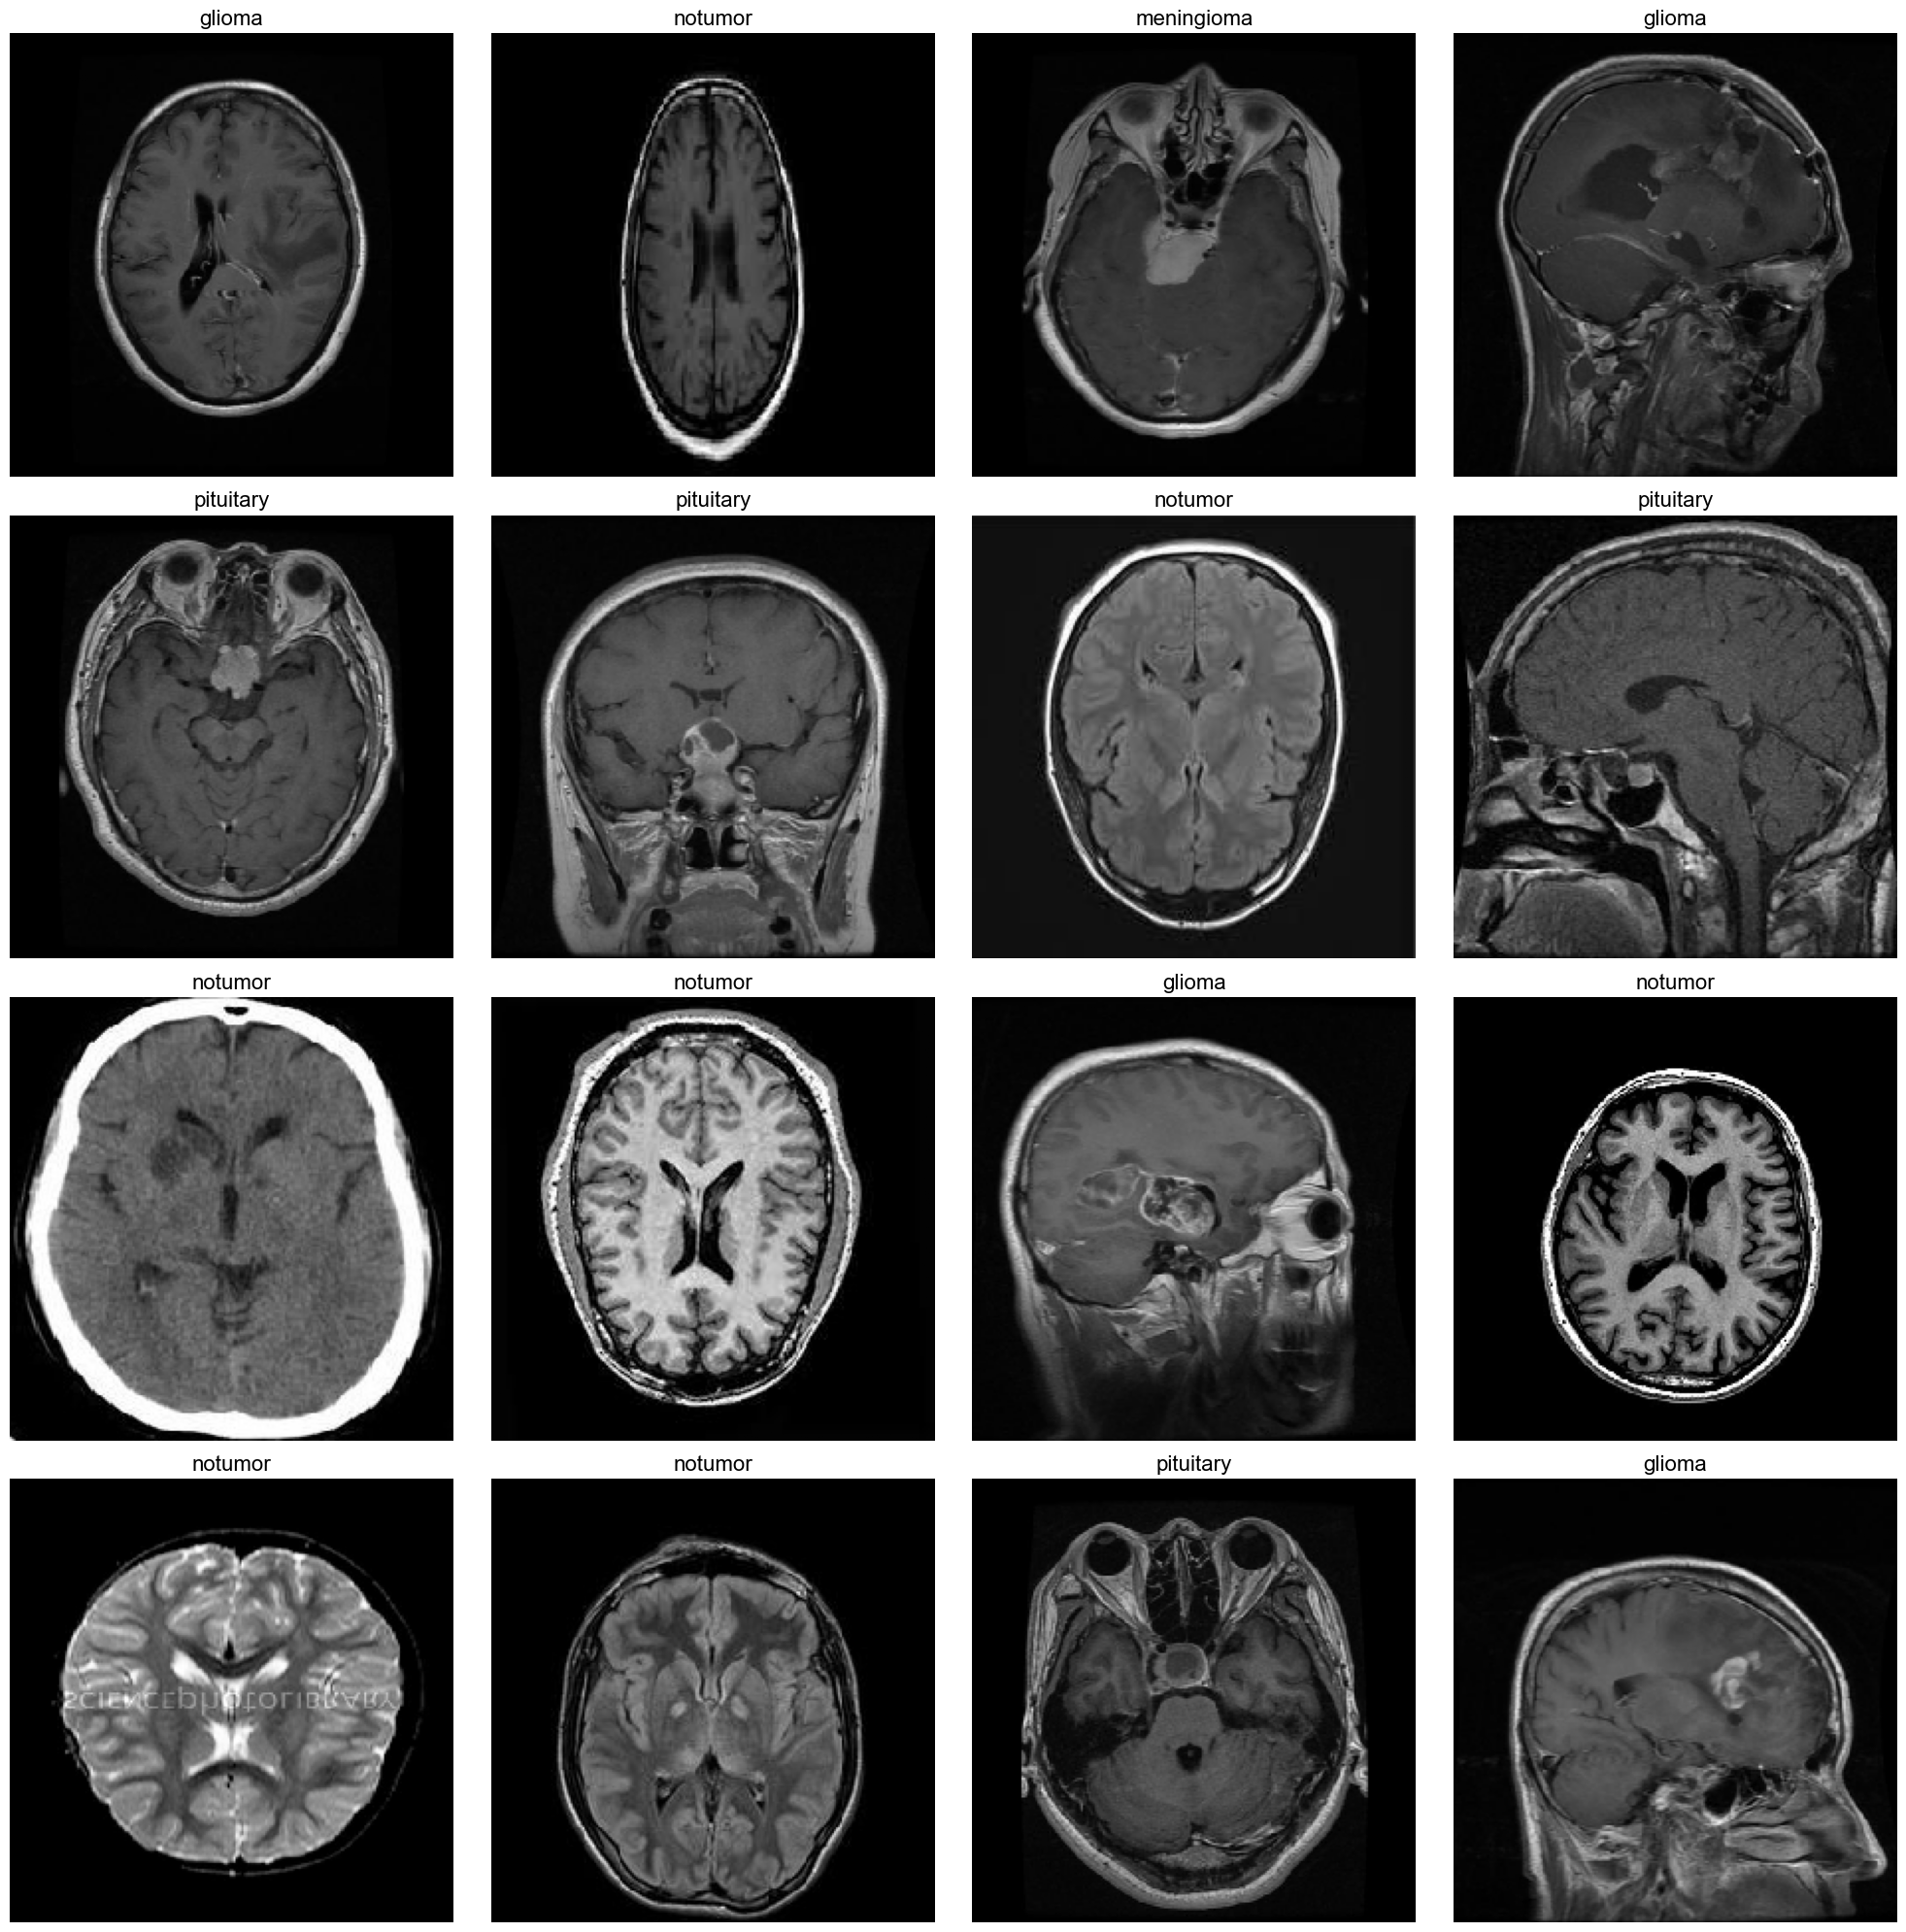

In [15]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator
# # difference between next iterator and for iterator


plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'black', fontsize= 16)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [16]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu", input_shape= img_shape))
model.add(MaxPooling2D())
    
model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D())
    
model.add(Flatten())
    
model.add(Dense(64,activation = "relu"))
model.add(Dense(32,activation = "relu"))
model.add(Dense(class_count, activation = "softmax"))


2024-11-09 13:50:32.659158: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-11-09 13:50:32.659360: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-11-09 13:50:32.659379: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-11-09 13:50:32.659569: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-09 13:50:32.659901: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [17]:
# Compile model
model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │    12,845,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,866,724 (49.08 MB)

 Trainable params: 12,866,724 (49.08 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
epochs = 10   # number of all epochs in training

history = model.fit(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/10


2024-11-09 13:52:24.455628: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


357/357 ━━━━━━━━━━━━━━━━━━━━ 60s 153ms/step - accuracy: 0.7163 - loss: 23.9974 - val_accuracy: 0.8763 - val_loss: 0.3506
Epoch 2/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 54s 153ms/step - accuracy: 0.9563 - loss: 0.1425 - val_accuracy: 0.9176 - val_loss: 0.2770
Epoch 3/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 54s 152ms/step - accuracy: 0.9882 - loss: 0.0500 - val_accuracy: 0.9237 - val_loss: 0.2977
Epoch 4/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 56s 157ms/step - accuracy: 0.9961 - loss: 0.0191 - val_accuracy: 0.9298 - val_loss: 0.2871
Epoch 5/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 58s 162ms/step - accuracy: 0.9991 - loss: 0.0070 - val_accuracy: 0.9252 - val_loss: 0.3118
Epoch 6/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 57s 159ms/step - accuracy: 0.9992 - loss: 0.0066 - val_accuracy: 0.9344 - val_loss: 0.3132
Epoch 7/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 59s 164ms/step - accuracy: 0.9991 - loss: 0.0027 - val_accuracy: 0.9328 - val_loss: 0.3397
Epoch 8/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 55s 155ms/step - accuracy: 1.0000 - loss: 7.8260e-04 

In [19]:
# Create a new MLP model
model2 = Sequential([
    Flatten(input_shape=img_shape),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(class_count, activation='softmax')
])

model2.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history2 = model2.fit(train_gen, epochs=epochs, verbose=1, validation_data=valid_gen, shuffle=False)

Epoch 1/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 34s 91ms/step - accuracy: 0.5520 - loss: 808.9548 - val_accuracy: 0.7084 - val_loss: 174.2581
Epoch 2/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 30s 84ms/step - accuracy: 0.7124 - loss: 190.3234 - val_accuracy: 0.4183 - val_loss: 582.9382
Epoch 3/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 31s 88ms/step - accuracy: 0.7280 - loss: 167.3611 - val_accuracy: 0.7298 - val_loss: 147.5455
Epoch 4/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 30s 85ms/step - accuracy: 0.7597 - loss: 135.4623 - val_accuracy: 0.7206 - val_loss: 195.7996
Epoch 5/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 29s 82ms/step - accuracy: 0.7805 - loss: 125.9301 - val_accuracy: 0.6992 - val_loss: 177.7454
Epoch 6/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 29s 80ms/step - accuracy: 0.7787 - loss: 94.3191 - val_accuracy: 0.7389 - val_loss: 152.6140
Epoch 7/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 26s 72ms/step - accuracy: 0.7929 - loss: 92.3983 - val_accuracy: 0.7634 - val_loss: 121.1792
Epoch 8/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 26s 72ms/step - accuracy

In [20]:
# Print model summary
model2.summary()



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │    19,267,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,828,686 (220.60 MB)

 Trainable params: 19,276,228 (73.53 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 38,552,458 (147.07 MB)

In [21]:
# Load the VGG16 model without the top (fully connected) layers
vgg_base = keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=img_shape)

# Freeze the VGG16 base model
vgg_base.trainable = False

# Create a new model on top of the VGG16 base
model3 = Sequential([
    vgg_base,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(class_count, activation='softmax')
])

model3.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history3 = model3.fit(train_gen, epochs=epochs, verbose=1, validation_data=valid_gen, shuffle=False)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 34s 1us/step
Epoch 1/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 213s 590ms/step - accuracy: 0.7920 - loss: 7.6643 - val_accuracy: 0.9099 - val_loss: 0.5768
Epoch 2/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 217s 607ms/step - accuracy: 0.9595 - loss: 0.2097 - val_accuracy: 0.9542 - val_loss: 0.3589
Epoch 3/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 225s 629ms/step - accuracy: 0.9873 - loss: 0.0613 - val_accuracy: 0.9664 - val_loss: 0.2270
Epoch 4/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 232s 649ms/step - accuracy: 0.9903 - loss: 0.0382 - val_accuracy: 0.9420 - val_loss: 0.4574
Epoch 5/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 242s 677ms/step - accuracy: 0.9844 - loss: 0.0716 - val_accuracy: 0.9649 - val_loss: 0.2913
Epoch 6/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 232s 650ms/step - accuracy: 0.9847 - loss: 0.0952 - val_accuracy: 0.9603 - val_loss: 0.2328
Epoch 7/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 232s 650ms/step - accuracy: 0.9911 - loss: 0.0398 - val_accuracy: 0.9618 - val_loss: 0.2973
Epoch 8/10
357/357 ━━━━━

In [22]:
# Print model summary
model3.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,986,126 (129.65 MB)

 Trainable params: 6,423,812 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 12,847,626 (49.01 MB)

# Model1 Performance

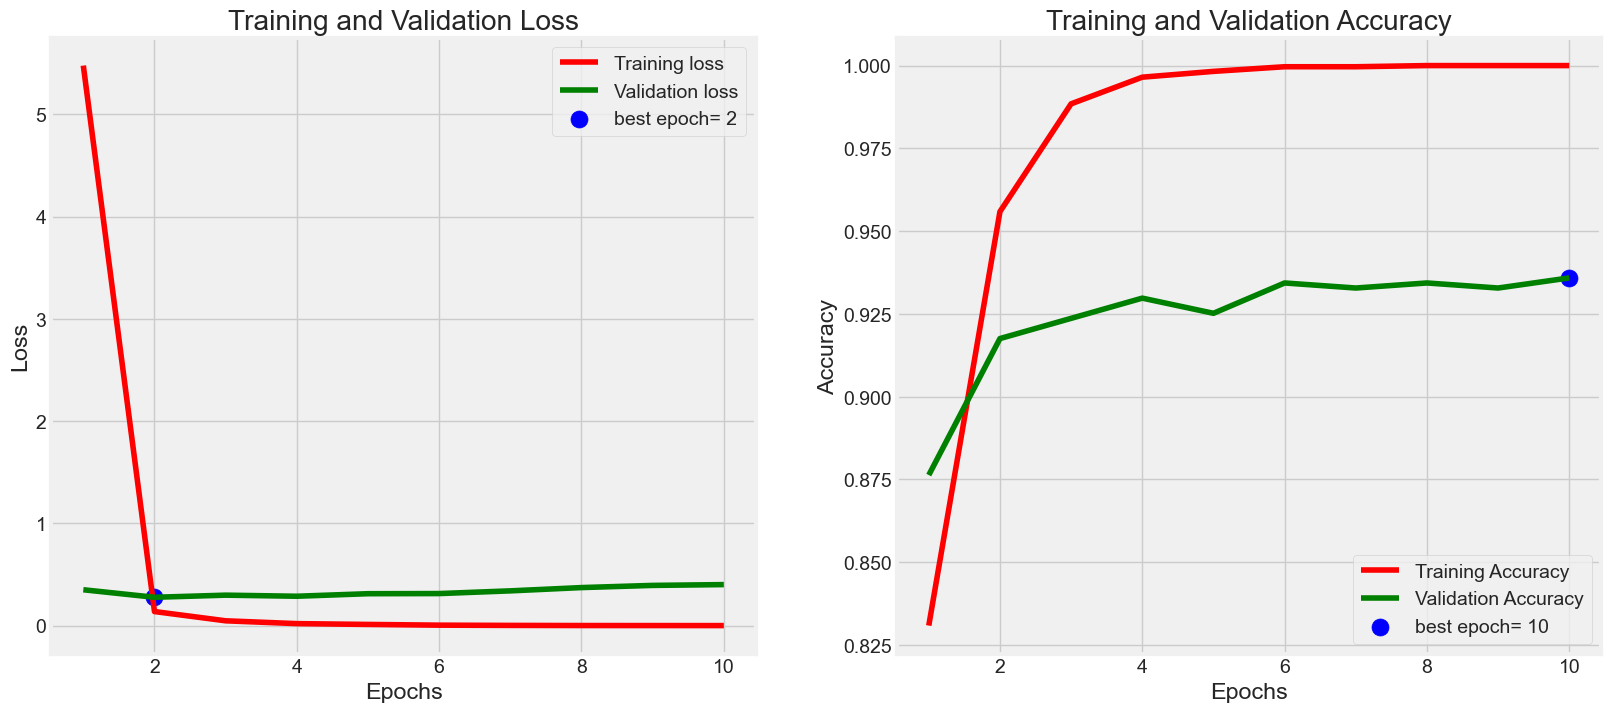

In [23]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

# Model2 Performance

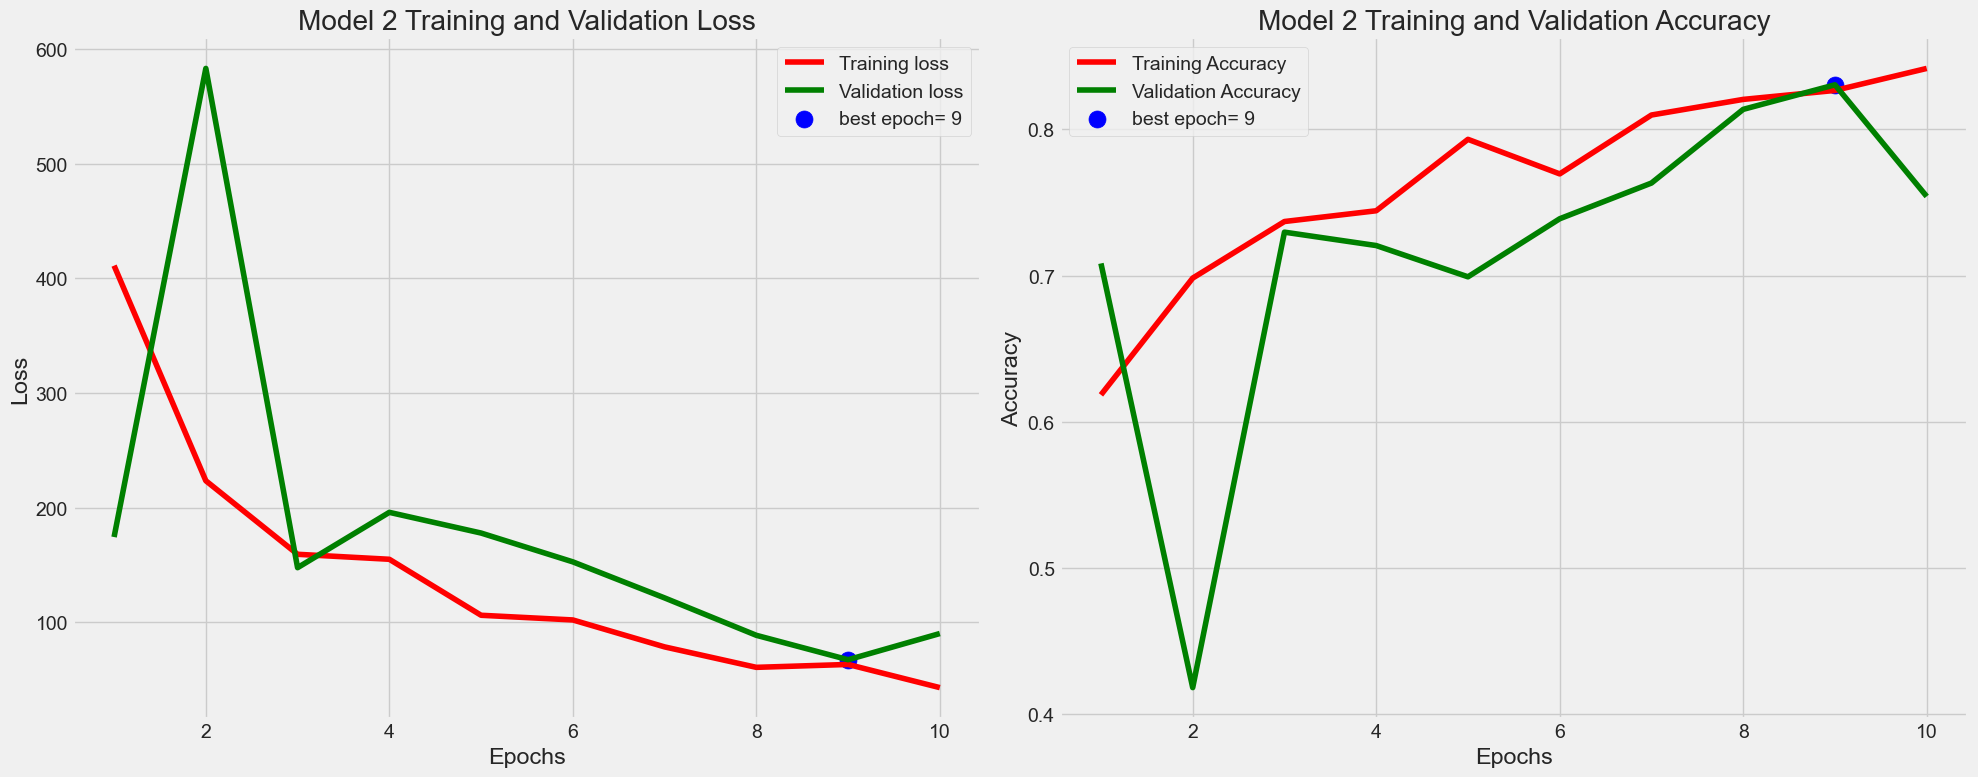

In [24]:
# Define needed variables for model2
tr_acc_model2 = history2.history['accuracy']
tr_loss_model2 = history2.history['loss']
val_acc_model2 = history2.history['val_accuracy']
val_loss_model2 = history2.history['val_loss']
index_loss_model2 = np.argmin(val_loss_model2)
val_lowest_model2 = val_loss_model2[index_loss_model2]
index_acc_model2 = np.argmax(val_acc_model2)
acc_highest_model2 = val_acc_model2[index_acc_model2]

Epochs_model2 = [i+1 for i in range(len(tr_acc_model2))]
loss_label_model2 = f'best epoch= {str(index_loss_model2 + 1)}'
acc_label_model2 = f'best epoch= {str(index_acc_model2 + 1)}'

# Plot training history for model2
plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs_model2, tr_loss_model2, 'r', label='Training loss')
plt.plot(Epochs_model2, val_loss_model2, 'g', label='Validation loss')
plt.scatter(index_loss_model2 + 1, val_lowest_model2, s=150, c='blue', label=loss_label_model2)
plt.title('Model 2 Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs_model2, tr_acc_model2, 'r', label='Training Accuracy')
plt.plot(Epochs_model2, val_acc_model2, 'g', label='Validation Accuracy')
plt.scatter(index_acc_model2 + 1, acc_highest_model2, s=150, c='blue', label=acc_label_model2)
plt.title('Model 2 Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# Model3 Preformance

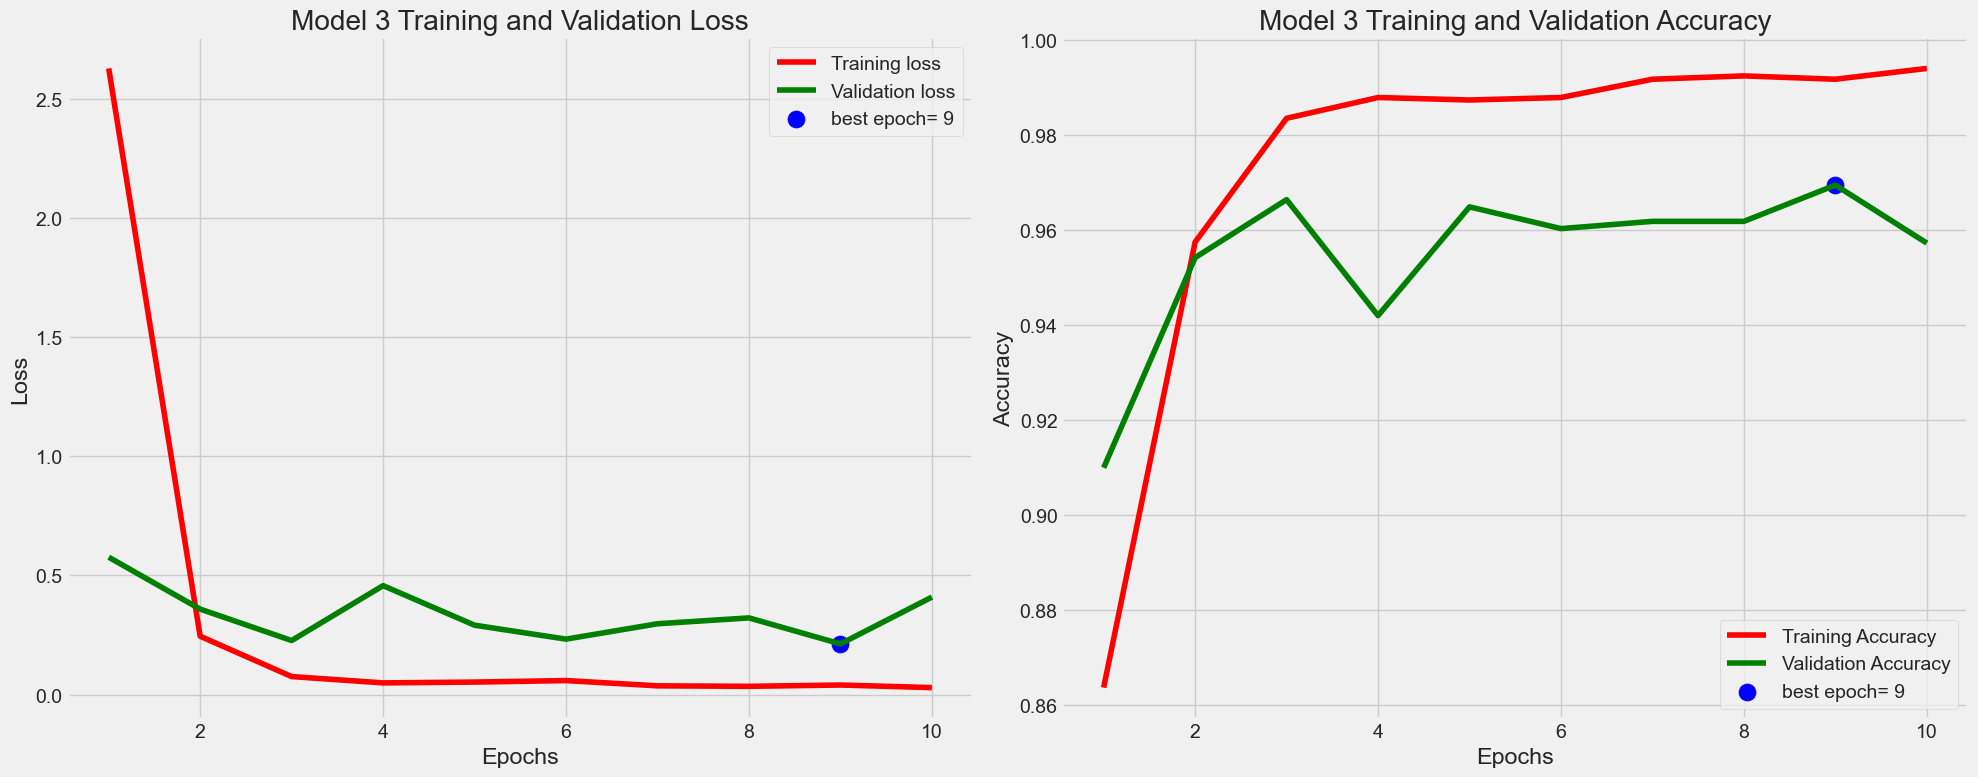

In [26]:
# Define needed variables for model3
tr_acc_model3 = history3.history['accuracy']
tr_loss_model3 = history3.history['loss']
val_acc_model3 = history3.history['val_accuracy']
val_loss_model3 = history3.history['val_loss']
index_loss_model3 = np.argmin(val_loss_model3)
val_lowest_model3 = val_loss_model3[index_loss_model3]
index_acc_model3 = np.argmax(val_acc_model3)
acc_highest_model3 = val_acc_model3[index_acc_model3]

Epochs_model3 = [i+1 for i in range(len(tr_acc_model3))]
loss_label_model3 = f'best epoch= {str(index_loss_model3 + 1)}'
acc_label_model3 = f'best epoch= {str(index_acc_model3 + 1)}'

# Plot training history for model3
plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs_model3, tr_loss_model3, 'r', label='Training loss')
plt.plot(Epochs_model3, val_loss_model3, 'g', label='Validation loss')
plt.scatter(index_loss_model3 + 1, val_lowest_model3, s=150, c='blue', label=loss_label_model3)
plt.title('Model 3 Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs_model3, tr_acc_model3, 'r', label='Training Accuracy')
plt.plot(Epochs_model3, val_acc_model3, 'g', label='Validation Accuracy')
plt.scatter(index_acc_model3 + 1, acc_highest_model3, s=150, c='blue', label=acc_label_model3)
plt.title('Model 3 Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [27]:
##CNN
train_score = model.evaluate(train_gen, verbose= 1)
valid_score = model.evaluate(valid_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

357/357 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 1.0000 - loss: 8.7983e-05
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.9350 - loss: 0.5250
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9545 - loss: 0.1905
Train Loss:  9.297084034187719e-05
Train Accuracy:  1.0
--------------------
Validation Loss:  0.40091952681541443
Validation Accuracy:  0.9358778595924377
--------------------
Test Loss:  0.15682648122310638
Test Accuracy:  0.9649389982223511


In [28]:
#MLP Tensorflow
train_score_model2 = model2.evaluate(train_gen, verbose=1)
valid_score_model2 = model2.evaluate(valid_gen, verbose=1)
test_score_model2 = model2.evaluate(test_gen, verbose=1)

print("Model 2 Train Loss: ", train_score_model2[0])
print("Model 2 Train Accuracy: ", train_score_model2[1])
print('-' * 20)
print("Model 2 Validation Loss: ", valid_score_model2[0])
print("Model 2 Validation Accuracy: ", valid_score_model2[1])
print('-' * 20)
print("Model 2 Test Loss: ", test_score_model2[0])
print("Model 2 Test Accuracy: ", test_score_model2[1])


357/357 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - accuracy: 0.8099 - loss: 36.0432
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7644 - loss: 89.4072
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7685 - loss: 74.7544
Model 2 Train Loss:  35.03981018066406
Model 2 Train Accuracy:  0.8219537734985352
--------------------
Model 2 Validation Loss:  90.1248779296875
Model 2 Validation Accuracy:  0.7541984915733337
--------------------
Model 2 Test Loss:  66.1715316772461
Model 2 Test Accuracy:  0.7820122241973877


In [29]:
#VGG16
train_score_model3 = model3.evaluate(train_gen, verbose=1)
valid_score_model3 = model3.evaluate(valid_gen, verbose=1)
test_score_model3 = model3.evaluate(test_gen, verbose=1)

print("Model 3 Train Loss: ", train_score_model3[0])
print("Model 3 Train Accuracy: ", train_score_model3[1])
print('-' * 20)
print("Model 3 Validation Loss: ", valid_score_model3[0])
print("Model 3 Validation Accuracy: ", valid_score_model3[1])
print('-' * 20)
print("Model 3 Test Loss: ", test_score_model3[0])
print("Model 3 Test Accuracy: ", test_score_model3[1])


357/357 ━━━━━━━━━━━━━━━━━━━━ 192s 536ms/step - accuracy: 0.9922 - loss: 0.0326
41/41 ━━━━━━━━━━━━━━━━━━━━ 23s 555ms/step - accuracy: 0.9586 - loss: 0.4139
41/41 ━━━━━━━━━━━━━━━━━━━━ 23s 553ms/step - accuracy: 0.9558 - loss: 0.2557
Model 3 Train Loss:  0.03603585436940193
Model 3 Train Accuracy:  0.9912465214729309
--------------------
Model 3 Validation Loss:  0.4092671871185303
Model 3 Validation Accuracy:  0.9572519063949585
--------------------
Model 3 Test Loss:  0.25113263726234436
Model 3 Test Accuracy:  0.9542682766914368


In [30]:
#CNN
preds = model.predict(test_gen)  
y_pred = np.argmax(preds, axis=1) 

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step


In [31]:
#MLP
preds_model2 = model2.predict(test_gen)  
y_pred_model2 = np.argmax(preds_model2, axis=1) 


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


In [32]:
#VGG16
preds_model3 = model3.predict(test_gen)  
y_pred_model3 = np.argmax(preds_model3, axis=1) 


41/41 ━━━━━━━━━━━━━━━━━━━━ 23s 559ms/step


## Confusion Matrices and Classification report

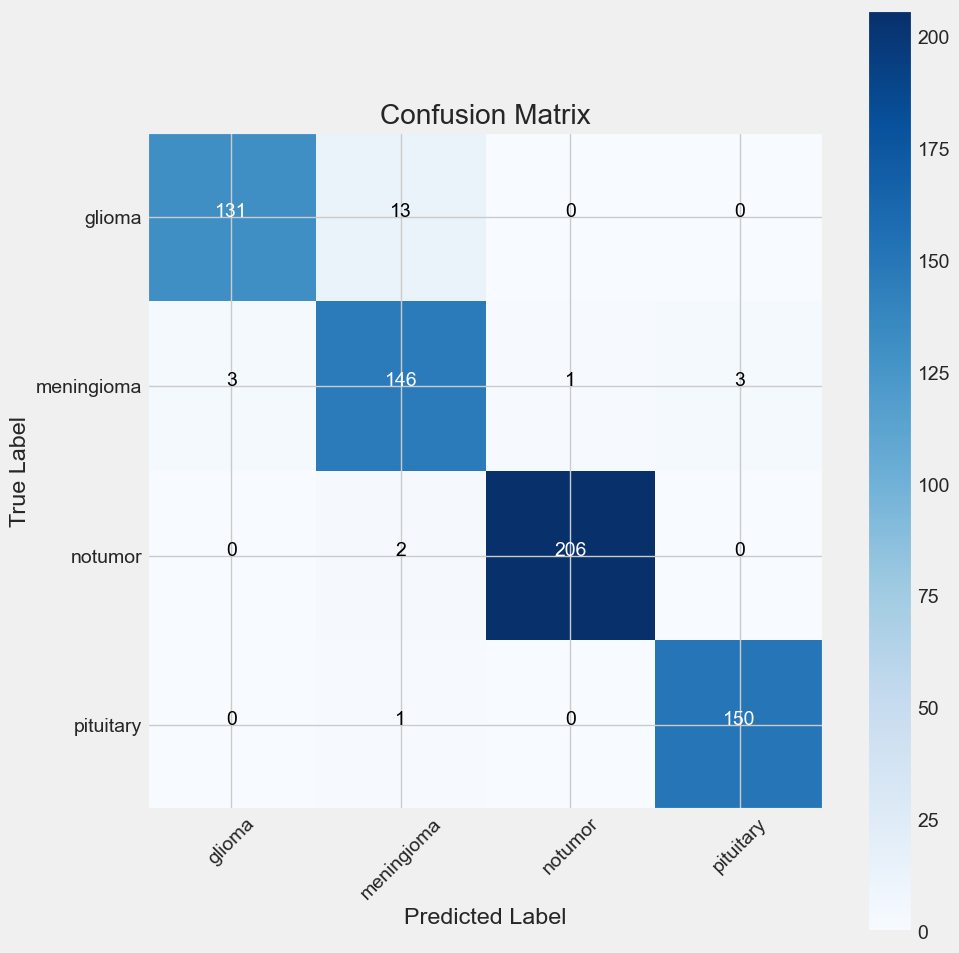

In [33]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
cm

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
    
    
plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

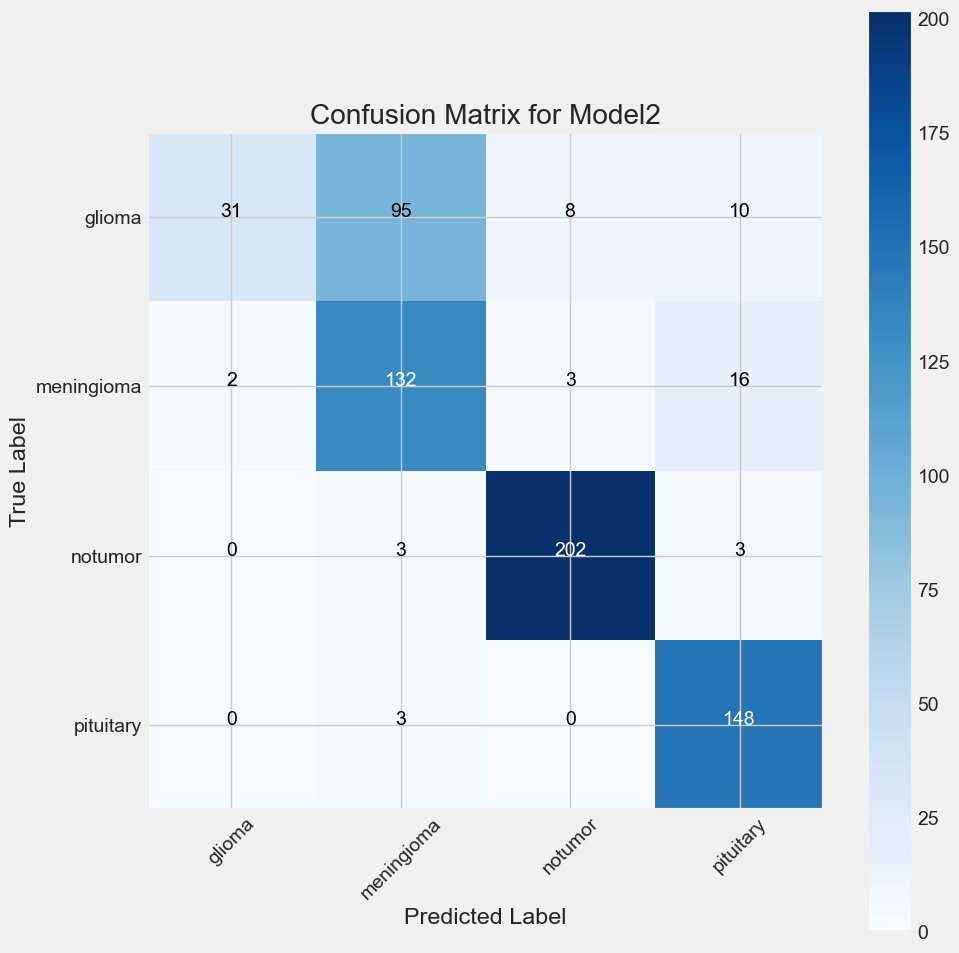

In [34]:
g_dict_model2 = test_gen.class_indices
classes_model2 = list(g_dict_model2.keys())

# Confusion matrix for model2
cm_model2 = confusion_matrix(test_gen.classes, y_pred_model2)
cm_model2

plt.figure(figsize= (10, 10))
plt.imshow(cm_model2, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix for Model2')
plt.colorbar()

tick_marks_model2 = np.arange(len(classes_model2))
plt.xticks(tick_marks_model2, classes_model2, rotation= 45)
plt.yticks(tick_marks_model2, classes_model2)

thresh_model2 = cm_model2.max() / 2.
for i, j in itertools.product(range(cm_model2.shape[0]), range(cm_model2.shape[1])):
    plt.text(j, i, cm_model2[i, j], horizontalalignment= 'center', color= 'white' if cm_model2[i, j] > thresh_model2 else 'black')
    
    
plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()


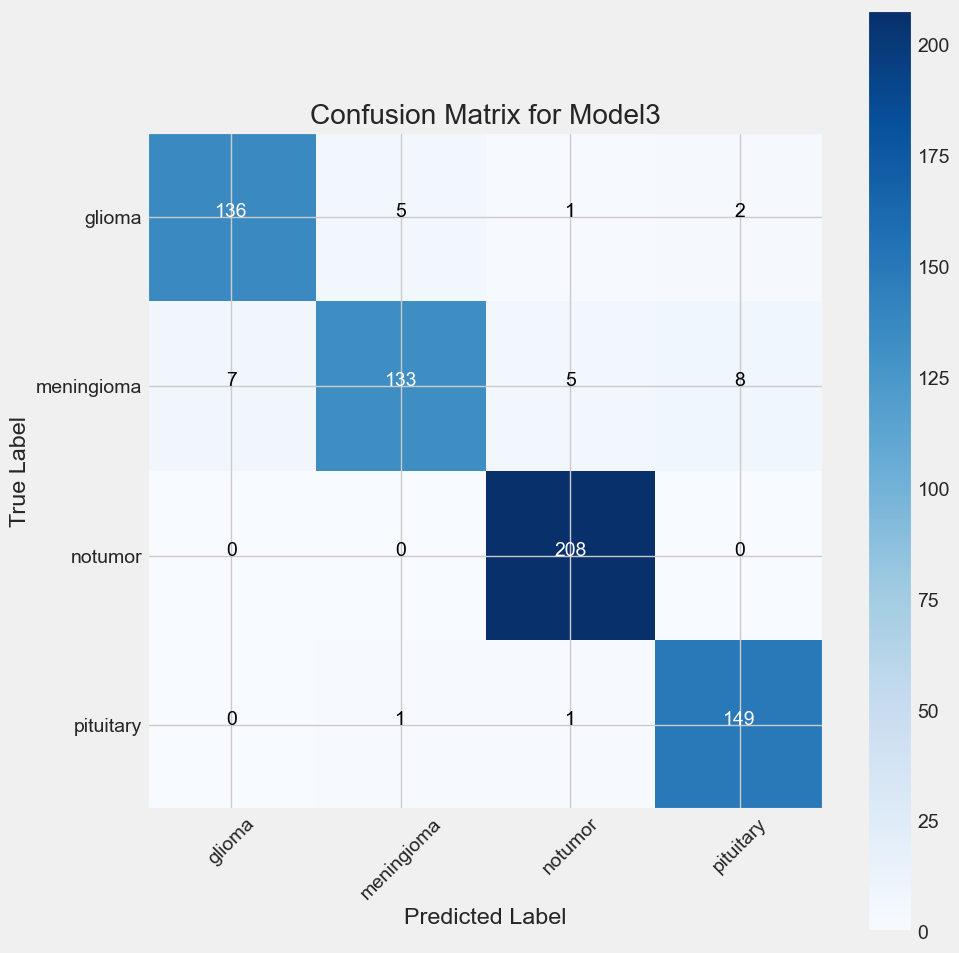

In [35]:
g_dict_model3 = test_gen.class_indices
classes_model3 = list(g_dict_model3.keys())

# Confusion matrix for model3
cm_model3 = confusion_matrix(test_gen.classes, y_pred_model3)
cm_model3

plt.figure(figsize= (10, 10))
plt.imshow(cm_model3, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix for Model3')
plt.colorbar()

tick_marks_model3 = np.arange(len(classes_model3))
plt.xticks(tick_marks_model3, classes_model3, rotation= 45)
plt.yticks(tick_marks_model3, classes_model3)

thresh_model3 = cm_model3.max() / 2.
for i, j in itertools.product(range(cm_model3.shape[0]), range(cm_model3.shape[1])):
    plt.text(j, i, cm_model3[i, j], horizontalalignment= 'center', color= 'white' if cm_model3[i, j] > thresh_model3 else 'black')
    
    
plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()


In [36]:
#CNN Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

      glioma       0.98      0.91      0.94       144
  meningioma       0.90      0.95      0.93       153
     notumor       1.00      0.99      0.99       208
   pituitary       0.98      0.99      0.99       151

    accuracy                           0.96       656
   macro avg       0.96      0.96      0.96       656
weighted avg       0.97      0.96      0.97       656



In [37]:
#MLP Classificatoin Report
print(classification_report(test_gen.classes, y_pred_model2, target_names= classes_model2))


              precision    recall  f1-score   support

      glioma       0.94      0.22      0.35       144
  meningioma       0.57      0.86      0.68       153
     notumor       0.95      0.97      0.96       208
   pituitary       0.84      0.98      0.90       151

    accuracy                           0.78       656
   macro avg       0.82      0.76      0.72       656
weighted avg       0.83      0.78      0.75       656



In [38]:
#VGG16 Classification Report
print(classification_report(test_gen.classes, y_pred_model3, target_names= classes_model3))


              precision    recall  f1-score   support

      glioma       0.95      0.94      0.95       144
  meningioma       0.96      0.87      0.91       153
     notumor       0.97      1.00      0.98       208
   pituitary       0.94      0.99      0.96       151

    accuracy                           0.95       656
   macro avg       0.95      0.95      0.95       656
weighted avg       0.95      0.95      0.95       656



In [40]:
model3.save("brain_tumor_detection_model.h5")
